In [ ]:
import pandas as pd

#### Loading data to Data Frame

In [ ]:
df_clean = pd.read_csv("ClaimsRegister.csv")

#### Dropping unnecessary columns

In [ ]:
# List of columns to keep
columns_to_keep = [
#   "POLICYSTATUS", 
    "ORIGINALINVOICEGROSSAMOUNT", 
    "RECOVEREDAMOUNT", 
    "RECOVERYDISCOUNTPBC", 
    "NHIFAMOUNTPBC", 
    "INVLINEPBCDISCOUNTAMOUNT", 
    "INVLINEPBCDENIEDAMOUNT", 
    "BENEFITEXCESSAPPLIED", 
    "INVOICEDAMOUNT", 
    "SETTLEDAMOUNT", 
    "INVOICELINEUSERSTATUS", 
    "INVOICECURRENCYDENIEDAMOUNT", 
    "ReasonText"
]

# Filter the DataFrame to keep only the specified columns
df_clean = df_clean[columns_to_keep]

# Display the updated DataFrame
df_clean.head()


#### Extracting Variance and Prescribed Amount

In [ ]:
import regex as re
# We create a function extract_prescribed_amount that uses regular expressions to find and extract text between = and ). This function:
def extract_prescribed_amount(text):
    if isinstance(text, str):  # Check if the input is a string
        match = re.search(r'=(.*?)\)', text)
        if match:
            return match.group(1).strip()  # Extract the amount and strip extra spaces
    return None  # Return None if input is not a string or no match is found

# Apply the function
df_clean['Prescribed Amount'] = df_clean['ReasonText'].apply(extract_prescribed_amount)

# Convert 'Prescribed Amount' to numeric, forcing errors to NaN (if any non-numeric values are present)
df_clean['Prescribed Amount'] = pd.to_numeric(df_clean['Prescribed Amount'], errors='coerce')

# Calculate the 'Variance' column
df_clean['Variance'] = df_clean['INVOICEDAMOUNT'] - df_clean['Prescribed Amount']


In [ ]:
# Drop "ReasonText"
df_clean = df_clean.drop(columns=["ReasonText"])

####  Filling missing values with mode for categorical values and mean for numerical values

In [ ]:
# Fill object (categorical) columns with mode
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

# Fill non-object (numerical) columns with mean
for col in df_clean.select_dtypes(exclude=['object']).columns:
    df_clean[col].fillna(df_clean[col].mean(), inplace=True)

# Check again for null values
null_values_after_fill = df_clean.isnull().sum()

# Display the count of null values for each column after filling
null_values_after_fill


In [ ]:
# Check data types
print(df_clean.dtypes)


#### Filtering the original data which reduces to 879,307  rows out of which 827,677  are paid and 51630 are declined

In [ ]:
# Filter the DataFrame based on the INVOICELINEUSERSTATUS column
filtered_df = df_clean[df_clean['INVOICELINEUSERSTATUS'].isin(['Paid', 'NP - Not to be Paid'])]

```
```

```
```

```
```
# Deep Learning Model

#### Loading necesssary libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from tensorflow import keras
from tensorflow.keras import layers


#### Defining Target

In [ ]:
# Separate features and target variable
X = filtered_df.drop(columns=['INVOICELINEUSERSTATUS'])
y = filtered_df['INVOICELINEUSERSTATUS'].map({'Paid': 0, 'NP - Not to be Paid': 1})  # Convert to binary


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [ ]:
def create_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
import os

# Ensure the 'models' directory exists for saving the models
os.makedirs("models", exist_ok=True)

# Set up K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_resampled), start=1):
    # Use iloc to index rows based on integer positions
    X_k_train, X_k_val = X_train_resampled.iloc[train_index], X_train_resampled.iloc[val_index]
    y_k_train, y_k_val = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

    # Create and train the model
    model = create_model(input_shape=(X_k_train.shape[1],))
    model.fit(X_k_train, y_k_train, epochs=10, batch_size=32, verbose=1)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_k_val, y_k_val)
    accuracies.append(val_accuracy)

    # Save the model for this fold
    model.save(f"models/model_fold_{fold}.h5")
    print(f"Model for fold {fold} saved.")

# Output the average accuracy across folds
print(f'Average K-Fold Accuracy: {np.mean(accuracies)}')


# Predictions

In [138]:
# Load DL_deep.csv for predictions
df_predict = pd.read_csv("DL_deep.csv")

# Keep only relevant columns and process them similarly to ClaimsRegister.csv
columns_to_keep = [
    "ORIGINALINVOICEGROSSAMOUNT", 
    "RECOVEREDAMOUNT", 
    "RECOVERYDISCOUNTPBC", 
    "NHIFAMOUNTPBC", 
    "INVLINEPBCDISCOUNTAMOUNT", 
    "INVLINEPBCDENIEDAMOUNT", 
    "BENEFITEXCESSAPPLIED", 
    "INVOICEDAMOUNT", 
    "SETTLEDAMOUNT", 
    "INVOICELINEUSERSTATUS", 
    "INVOICECURRENCYDENIEDAMOUNT", 
    "ReasonText"
]
df_predict = df_predict[columns_to_keep]

# Apply extract_prescribed_amount function and process other columns
df_predict['Prescribed Amount'] = df_predict['ReasonText'].apply(extract_prescribed_amount)
df_predict['Prescribed Amount'] = pd.to_numeric(df_predict['Prescribed Amount'], errors='coerce')
df_predict['Variance'] = df_predict['INVOICEDAMOUNT'] - df_predict['Prescribed Amount']
df_predict = df_predict.drop(columns=["ReasonText"])

# Handle missing values
for col in df_predict.select_dtypes(include=['object']).columns:
    df_predict[col].fillna(df_predict[col].mode()[0], inplace=True)
for col in df_predict.select_dtypes(exclude=['object']).columns:
    df_predict[col].fillna(df_predict[col].mean(), inplace=True)

# Load a pre-trained model and make predictions
from tensorflow.keras.models import load_model
model = load_model("models/model_fold_1.h5")  # Load one of the trained models

# Prepare input data and make predictions
X_predict = df_predict.drop(columns=['INVOICELINEUSERSTATUS'], errors='ignore')
predictions = model.predict(X_predict)

# Output predictions
print(predictions)


7674/7674 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step
[[0.        ]
 [0.        ]
 [0.98776007]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]


In [182]:
# Load DL_deep.csv for predictions
df_predict = pd.read_csv("DL_deep.csv")

# Keep only relevant columns
columns_to_keep = [
    "ORIGINALINVOICEGROSSAMOUNT", 
    "RECOVEREDAMOUNT", 
    "RECOVERYDISCOUNTPBC", 
    "NHIFAMOUNTPBC", 
    "INVLINEPBCDISCOUNTAMOUNT", 
    "INVLINEPBCDENIEDAMOUNT", 
    "BENEFITEXCESSAPPLIED", 
    "INVOICEDAMOUNT", 
    "SETTLEDAMOUNT", 
    "INVOICELINEUSERSTATUS", 
    "INVOICECURRENCYDENIEDAMOUNT", 
    "ReasonText"
]
df_predict = df_predict[columns_to_keep]

# Process ReasonText to extract prescribed amount
df_predict['Prescribed Amount'] = df_predict['ReasonText'].apply(extract_prescribed_amount)
df_predict['Prescribed Amount'] = pd.to_numeric(df_predict['Prescribed Amount'], errors='coerce')
df_predict['Variance'] = df_predict['INVOICEDAMOUNT'] - df_predict['Prescribed Amount']
df_predict = df_predict.drop(columns=["ReasonText"])

# Handle missing values
for col in df_predict.select_dtypes(include=['object']).columns:
    df_predict[col].fillna(df_predict[col].mode()[0], inplace=True)
for col in df_predict.select_dtypes(exclude=['object']).columns:
    df_predict[col].fillna(df_predict[col].mean(), inplace=True)

# Load a pre-trained model and make predictions
from tensorflow.keras.models import load_model
model = load_model("models/model_fold_2.h5")  # Load one of the trained models

# Prepare input data for prediction and make predictions
X_predict = df_predict.drop(columns=['INVOICELINEUSERSTATUS'], errors='ignore')
predictions = model.predict(X_predict)

# Apply a threshold to get binary predictions
binary_predictions = (predictions > 0.5).astype(int)

# Add binary predictions to the original DataFrame
df_predict['Predicted_INVOICELINEUSERSTATUS'] = binary_predictions

# Save to a new CSV file
df_predict.to_csv("DL_deep_with_predictions4.csv", index=False)
print("Predictions saved to DL_deep_with_predictions.csv")


7674/7674 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
Predictions saved to DL_deep_with_predictions.csv


5496/5496 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step
Confusion Matrix:
[[163547   1989]
 [     5  10321]]


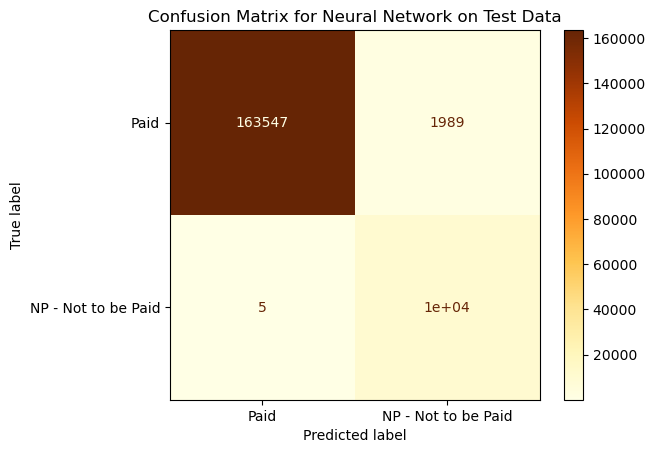

In [159]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and X_test are defined and preprocessed as in your training pipeline

# Make predictions on the test set
y_test_pred_proba = model.predict(X_test)
y_test_pred = (y_test_pred_proba > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix with a red color scheme
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Paid', 'NP - Not to be Paid'])
disp.plot(cmap='YlOrBr')
plt.title("Confusion Matrix for Neural Network on Test Data")
plt.show()


### Claims Prediction Analysis

Given the following claims data:

- **Out of 219,292 claims**:
  - **Predicted Paid Claims**: 204,465
  - **Actual Paid Claims**: 204,456
  - **Misclassified Paid Claims**: 9
  - **Predicted Declined Claims**: 14,827
  - **Actual Declined Claims**: 13,001
  - **Misclassified Declined Claims**: 1,826

#### Calculations

1. **True Positives (TP)**: Correctly predicted paid claims  
   $$ TP = 204,456 - 9 = 204,447 $$

2. **False Negatives (FN)**: Incorrectly predicted declined claims  
   $$ FN = 9 $$

3. **True Negatives (TN)**: Correctly predicted declined claims  
   $$ TN = 13,001 - 1,826 = 11,175 $$

4. **False Positives (FP)**: Incorrectly predicted paid claims  
   $$ FP = 1,826 $$

#### Accuracy Calculation

The accuracy is calculated as follows:

$$
\text{Accuracy} = \frac{204,447 + 11,175}{219,292}
$$

**Final Accuracy**:  
$$
\text{Accuracy} \approx 0.9770 \text{ or } 97.70\%
$$


```
```

```
```

```
```

```
```

```
```

```
```

# XGBoost

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Separate features and target variable
X = filtered_df.drop(columns=['INVOICELINEUSERSTATUS'])
y = filtered_df['INVOICELINEUSERSTATUS'].map({'Paid': 0, 'NP - Not to be Paid': 1})  # Convert to binary

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [150]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.5]
}

# Initialize XGBClassifier
xgb_clf = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Print best parameters
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 648 candidates, totalling 3240 fits


C:\Users\Pathways\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0.1, 'subsample': 0.8}


##### using the parameters manually to avoid doing the grid search again

In [166]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

# Define the model with specific parameters
xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    colsample_bytree=1,
    gamma=0.1,
    learning_rate=0.2,
    max_depth=7,
    n_estimators=200,
    reg_alpha=0.1,
    subsample=0.8
)

# Train the model on the resampled training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Load new data for predictions
df_predict = pd.read_csv("DL_deep.csv")

# Keep only relevant columns and process them similarly
columns_to_keep = [
    "ORIGINALINVOICEGROSSAMOUNT", 
    "RECOVEREDAMOUNT", 
    "RECOVERYDISCOUNTPBC", 
    "NHIFAMOUNTPBC", 
    "INVLINEPBCDISCOUNTAMOUNT", 
    "INVLINEPBCDENIEDAMOUNT", 
    "BENEFITEXCESSAPPLIED", 
    "INVOICEDAMOUNT", 
    "SETTLEDAMOUNT", 
    "INVOICELINEUSERSTATUS", 
    "INVOICECURRENCYDENIEDAMOUNT", 
    "ReasonText"
]
df_predict = df_predict[columns_to_keep]

# Process ReasonText to extract prescribed amount
df_predict['Prescribed Amount'] = df_predict['ReasonText'].apply(extract_prescribed_amount)
df_predict['Prescribed Amount'] = pd.to_numeric(df_predict['Prescribed Amount'], errors='coerce')
df_predict['Variance'] = df_predict['INVOICEDAMOUNT'] - df_predict['Prescribed Amount']
df_predict = df_predict.drop(columns=["ReasonText"])

# Handle missing values
for col in df_predict.select_dtypes(include=['object']).columns:
    df_predict[col].fillna(df_predict[col].mode()[0], inplace=True)
for col in df_predict.select_dtypes(exclude=['object']).columns:
    df_predict[col].fillna(df_predict[col].mean(), inplace=True)

# Prepare the input data for prediction
X_predict = df_predict.drop(columns=['INVOICELINEUSERSTATUS'], errors='ignore')

# Make predictions with the tuned model
predictions = xgb_model.predict(X_predict)

# Add predictions to the DataFrame
df_predict['Predicted_INVOICELINEUSERSTATUS'] = predictions

# Save predictions to a new CSV file
df_predict.to_csv("DL_deep_with_predictions3.csv", index=False)
print("Predictions saved to DL_deep_with_predictions3.csv")


Test Accuracy: 0.9920562713946163
Predictions saved to DL_deep_with_predictions3.csv


Confusion Matrix:
[[164183   1353]
 [    44  10282]]


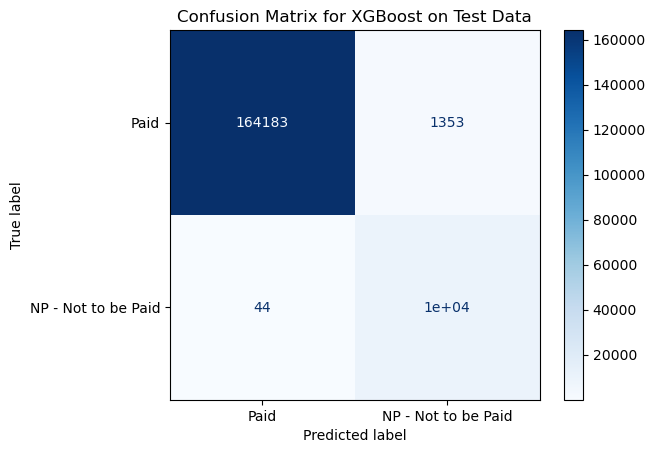

In [167]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Display the confusion matrix with a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Paid', 'NP - Not to be Paid'])
disp.plot(cmap='Blues')  # Change 'Blues' to any other color map if you prefer
plt.title("Confusion Matrix for XGBoost on Test Data")
plt.show()


### Claims Prediction Analysis

Given the following claims data:

- **Out of 219,292 claims**:
  - **Predicted Paid Claims**: 205,058
  - **Actual Paid Claims**: 205,030
  - **Misclassified Paid Claims**: 29
  - **Predicted Declined Claims**: 14,234
  - **Actual Declined Claims**: 12,981
  - **Misclassified Declined Claims**: 1,253

#### Calculations

1. **True Positives (TP)**: Correctly predicted paid claims  
   $$ TP = 205,030 - 29 = 205,001 $$

2. **False Negatives (FN)**: Incorrectly predicted declined claims  
   $$ FN = 29 $$

3. **True Negatives (TN)**: Correctly predicted declined claims  
   $$ TN = 12,981 - 1,253 = 11,728 $$

4. **False Positives (FP)**: Incorrectly predicted paid claims  
   $$ FP = 1,253 $$

#### Accuracy Calculation

The accuracy is calculated as follows:

$$
\text{Accuracy} = \frac{205,001 + 11,728}{219,292}
$$

**Final Accuracy**:  
$$
\text{Accuracy} \approx 0.9876 \text{ or } 98.76\%
$$


```
```

```
```

```
```

```
```


```
```

#  Linear Regression

In [140]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import os


In [141]:
# Assuming `filtered_df` is your main DataFrame with data ready for modeling
X = filtered_df.drop(columns=['INVOICELINEUSERSTATUS'])
y = filtered_df['INVOICELINEUSERSTATUS'].map({'Paid': 0, 'NP - Not to be Paid': 1})  # Convert to binary


In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [143]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [144]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)


In [145]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_resampled), start=1):
    X_k_train, X_k_val = X_train_resampled[train_index], X_train_resampled[val_index]
    y_k_train, y_k_val = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]

    # Create and train the logistic regression model
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(X_k_train, y_k_train)

    # Evaluate the model
    val_accuracy = model.score(X_k_val, y_k_val)
    accuracies.append(val_accuracy)

    print(f"Fold {fold} Accuracy: {val_accuracy}")

# Output the average accuracy across folds
print(f'Average K-Fold Accuracy: {np.mean(accuracies)}')


Fold 1 Accuracy: 0.972494591421031
Fold 2 Accuracy: 0.9741898458413408
Fold 3 Accuracy: 0.9734195185308243
Fold 4 Accuracy: 0.9740915818406983
Fold 5 Accuracy: 0.9735705439937173
Average K-Fold Accuracy: 0.9735532163255224


##### make predictions

In [147]:
# Load DL_deep.csv for predictions
df_predict = pd.read_csv("DL_deep.csv")

# Select relevant columns and preprocess them as in the training data
columns_to_keep = [
    "ORIGINALINVOICEGROSSAMOUNT", 
    "RECOVEREDAMOUNT", 
    "RECOVERYDISCOUNTPBC", 
    "NHIFAMOUNTPBC", 
    "INVLINEPBCDISCOUNTAMOUNT", 
    "INVLINEPBCDENIEDAMOUNT", 
    "BENEFITEXCESSAPPLIED", 
    "INVOICEDAMOUNT", 
    "SETTLEDAMOUNT", 
    "INVOICELINEUSERSTATUS", 
    "INVOICECURRENCYDENIEDAMOUNT", 
    "ReasonText"
]
df_predict = df_predict[columns_to_keep]

# Process ReasonText to extract prescribed amount
df_predict['Prescribed Amount'] = df_predict['ReasonText'].apply(extract_prescribed_amount)
df_predict['Prescribed Amount'] = pd.to_numeric(df_predict['Prescribed Amount'], errors='coerce')
df_predict['Variance'] = df_predict['INVOICEDAMOUNT'] - df_predict['Prescribed Amount']
df_predict = df_predict.drop(columns=["ReasonText"])

# Handle missing values
for col in df_predict.select_dtypes(include=['object']).columns:
    df_predict[col].fillna(df_predict[col].mode()[0], inplace=True)
for col in df_predict.select_dtypes(exclude=['object']).columns:
    df_predict[col].fillna(df_predict[col].mean(), inplace=True)

# Prepare the input data for prediction and scale it
X_predict = df_predict.drop(columns=['INVOICELINEUSERSTATUS'], errors='ignore')
X_predict_scaled = scaler.transform(X_predict)

# Make predictions
predictions = model.predict(X_predict_scaled)

# Add binary predictions to the original DataFrame
df_predict['Predicted_INVOICELINEUSERSTATUS'] = predictions

# Save to a new CSV file
df_predict.to_csv("DL_deep_with_predictions2.csv", index=False)
print("Predictions saved to DL_deep_with_predictions.csv")


Predictions saved to DL_deep_with_predictions.csv


##### confusion matrix

Confusion Matrix:
[[156825   8711]
 [     4  10322]]


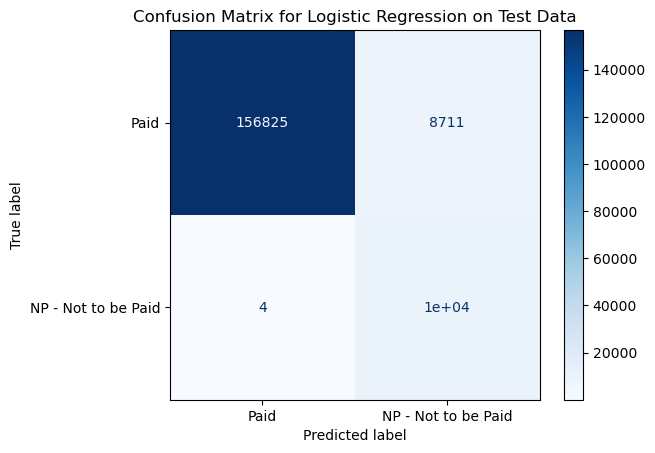

In [148]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Predict on the test set
y_test_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Paid', 'NP - Not to be Paid'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Logistic Regression on Test Data")
plt.show()


### Claims Prediction Analysis

Given the following claims data:

- **Out of 219,292 claims**:
  - **Predicted Paid Claims**: 199,402
  - **Actual Paid Claims**: 199,389
  - **Misclassified Paid Claims**: 14
  - **Predicted Declined Claims**: 19,890
  - **Actual Declined Claims**: 12,996
  - **Misclassified Declined Claims**: 6,894

#### Calculations

1. **True Positives (TP)**: Correctly predicted paid claims  
   $$ TP = 199,389 - 14 = 199,375 $$

2. **False Negatives (FN)**: Incorrectly predicted declined claims  
   $$ FN = 14 $$

3. **True Negatives (TN)**: Correctly predicted declined claims  
   $$ TN = 12,996 - 6,894 = 6,102 $$

4. **False Positives (FP)**: Incorrectly predicted paid claims  
   $$ FP = 6,894 $$

#### Accuracy Calculation

The accuracy is calculated as follows:

$$
\text{Accuracy} = \frac{199,375 + 6,102}{219,292}
$$

**Final Accuracy**: **93.70%**
